# Ungraded Lab: Feature Engineering with Weather Data

In this 1st exercise on feature engineering with time series data, you will practice data transformation with the [`weather dataset`](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/). 

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. 

These were collected every 10 minutes, beginning in 2003. For this lab, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book *Deep Learning with Python*.

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

You will perform data preprocessing so that the features can be used to train an LSTM using TensorFlow and Keras downstream. You will not be asked to train a model as the focus is on `feature preprocessing`. However in later courses of this specialization, you will get to learn more about time series forecasting, at which point you can retreive your saved tfrecords and train a neural net model for weather forecasting.

Upon completion, you will have

* Explored and visualized the weather time series dataset and declared its schema
* Transformed the data for modeling using TF Transform
* Prepared Training Dataset Windows from `TFTransformOutput`

## Imports

In [1]:
import os
import pprint
import tempfile
import urllib
import pandas as pd
import numpy as np

import absl
import tensorflow as tf
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen # csv df -> train-eval-splited & formated df
from tfx.components import ExampleValidator # stat + schema -> anomalies
from tfx.components import SchemaGen # stat->schema
from tfx.components import StatisticsGen # splited-formated-df ->stat
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.types import Channel
from tfx.utils.dsl_utils import external_input
from tfx.components.transform.component import Transform

from google.protobuf.json_format import MessageToDict

print(f'TFX version: {tfx.__version__}')
print(f'Tensorflow version: {tf.__version__}')

TFX version: 0.24.0
Tensorflow version: 2.4.1


## Setup dataset and directories

Let's then download the dataset and setup your pipeline directory.

In [2]:
# Create pipeline directory
!mkdir pipeline

# Create data directory
!mkdir -p data/climate

# Location of the pipeline metadata store
_pipeline_root = './pipeline/'

# Directory of the raw data files
_data_root = './data/climate'

# Path to the raw training data
_data_filepath = os.path.join(_data_root, 'jena_climate_2009_2016.csv')

mkdir: cannot create directory ‘pipeline’: File exists


In [3]:
# Download the dataset.
!wget -nc https://raw.githubusercontent.com/https-deeplearning-ai/MLEP-public/main/course2/week4-ungraded-lab/data/jena_climate_2009_2016.csv -P {_data_root}

File ‘./data/climate/jena_climate_2009_2016.csv’ already there; not retrieving.



Let's preview the first few rows. You will notice that almost all the features are numeric.

In [4]:
# Preview the dataset
!head {_data_filepath}

Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
01.01.2009 00:10:00,996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.8,0.72,1.5,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.2,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.5,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.0,0.32,0.63,214.3
01.01.2009 01:00:00,996.5,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
01.01.2009 01:10:00,996.5,-7.62,265.81,-8.3,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
01.01.2009 01:20:00,996.5,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.5,118.6
01.01.2009 01:30:00,996.5,-7.91,265.52,-8.73,9

You will also notice that there are quotes in the column names. It is up to you if you should keep it but for this exercise, it would be better to remove it so we don't have to factor it in when we're declaring the keys in the Transform module. Let's do that below.

In [5]:
# Load the CSV into a dataframe
df = pd.read_csv(f'{_data_filepath}')

# Remove the quotes in the column names
df.columns=df.columns.str.replace('"','')

# Save the changes
df.to_csv(f'{_data_filepath}', index=False)

# See the result
!head {_data_filepath}

Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
01.01.2009 00:10:00,996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.8,0.72,1.5,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.2,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.5,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.0,0.32,0.63,214.3
01.01.2009 01:00:00,996.5,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
01.01.2009 01:10:00,996.5,-7.62,265.81,-8.3,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
01.01.2009 01:20:00,996.5,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.5,118.6
01.01.2009 01:30:00,996.5,-7.91,265.52,-8.73,9

In [6]:
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


## Data Pipeline

Since you already know how to run TFX pipelines, we will just quickly go over the first few components. The main difference we need to discuss will be in the Transform part where you need to transform certain columns into usable signals.

## Create the InteractiveContext

As usual, you need to initialize the `InteractiveContext` so you can run the components in the notebook.

In [7]:
# Initialize the InteractiveContext
context = InteractiveContext(pipeline_root=_pipeline_root) #where the meta data locates

## ExampleGen: csv->formated df & train-eval split

You will then ingest the data from the dataframe you defined earlier. As with earlier labs, you may want to remove notebook checkpoints in case you get an error about different headers.

In [8]:
# Run CSV ExampleGen
example_gen = CsvExampleGen(input_base=_data_root)  
context.run(example_gen) # store the metadata generated by CsvExampleGen()

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 6
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 5
        type_id: 5
        uri: "./pipeline/CsvExampleGen/examples/6"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:41987089,xor_checksum:1626978466,sum_checksum:1626978466"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
        ))

## StatisticsGen: splited & formated df -> stat

Here, splited & formated df = example_gen.outputs['examples'], i.e. the output of ExampleGen

Next, you will generate the statistics that will be used by the next components. Feel free to also explore it when you run `context.show()`.

In [9]:
# Instantiate StatisticsGen with the ExampleGen ingested dataset
statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])

# Store the metadata generated by StatisticsGen()
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 7
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 6
        type_id: 7
        uri: "./pipeline/StatisticsGen/statistics/7"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 7
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
        ))

In [10]:
# Show the output statistics
context.show(statistics_gen.outputs['statistics'])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


From the charts above, you might notice that the minimum value for `wv (m/s)` is `-9999`. Those are pretty intense winds and based on the other data points, this just looks like a faulty measurement. You can also use the utilities below to inspect the dataset. You will notice this `-9999` value as an outlier in the `wv (m/s)` plot.

In [11]:
# Visualization Utilities
import matplotlib.pyplot as plt

# Color Palette
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

# Dataset Columns
feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)", 
    "rh (%)", 
    "VPmax (mbar)", 
    "VPact (mbar)", 
    "VPdef (mbar)", 
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

# Plots each column as a time series
def plot_ts(df, columns):
    """Plots each column as a time series
    Args:
        df: dataframe with 1)row-index as time stamp 2) each column as the ts of a feature
        columns: a list of column names
    """
    features = df[columns]
    fig, axes = plt.subplots(
        nrows=len(columns)//2 + len(columns)%2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i, col in enumerate(columns):
        c = colors[i % (len(colors))]
        t_data = df[col]
        t_data.index = df.index
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(col),
            rot=25,
        )
    ax.legend([col])
    plt.tight_layout()

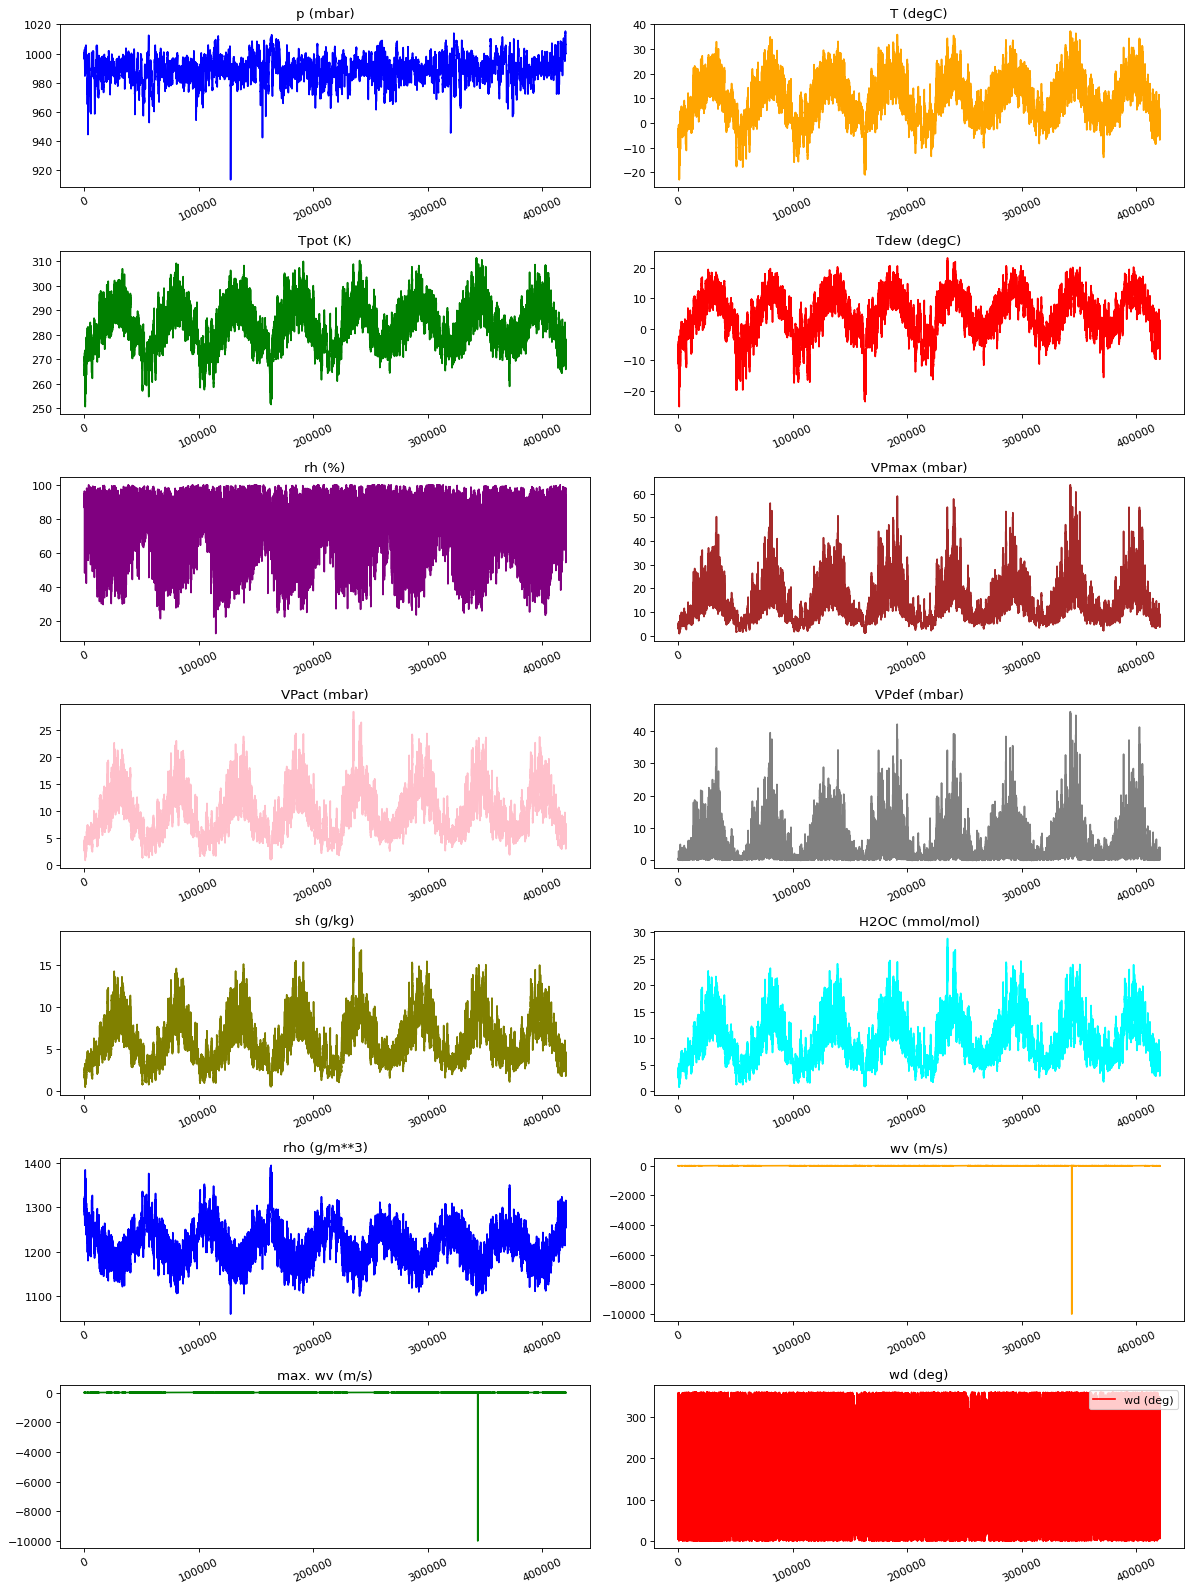

In [12]:
# Visualize the dataset
plot_ts(df, feature_keys)

In [ ]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)

def plot_pair(df, columns=None):
    """plot the pair-wise correlation of df using seaborn
    Args:
        df: dataframe
        columns: a list of column names
    
    """
    if columns:
        df1 = df[columns].copy()
    else:
        df1 = df.copy()
    # Create a pair grid instance
    import seaborn as sns
    grid = sns.PairGrid(data= df1,
                        vars = columns, size = 4)

    # Map the plots to the locations
    grid = grid.map_upper(plt.scatter, color = 'blue')
    grid = grid.map_upper(corr)
    grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')
    grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = 'darkred');
    
plot_pair(df)

In real projects, you will need to clean this up. If you want, you can **drop those rows with anomaly value from the CSV** and ingest the data again through ExampleGen. For this exercise however, we will just proceed to the next step.

## SchemaGen: stat -> schema 

You will now infer the schema based on the statistics artifact. 

NOTE: For the version of TFX you are using, you will have to explicitly set `infer_feature_shape=True` so the downstream TFX components (e.g. Transform) will parse input as a `Tensor` and **not** `SparseTensor`. If not set, you will have compatibility issues later when you run the transform.

In [14]:
# Instantiate SchemaGen with the StatisticsGen ingested dataset
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'], 
    infer_feature_shape=True
    )

# Run the component i.e. store the metadata generated by SchemaGen() 
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 8
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 7
        type_id: 9
        uri: "./pipeline/SchemaGen/schema/8"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 9
        name: "Schema"
        )]
        ))

In [15]:
# Visualize the schema
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'Date Time',BYTES,required,,-
'H2OC (mmol/mol)',FLOAT,required,,-
'T (degC)',FLOAT,required,,-
'Tdew (degC)',FLOAT,required,,-
'Tpot (K)',FLOAT,required,,-
'VPact (mbar)',FLOAT,required,,-
'VPdef (mbar)',FLOAT,required,,-
'VPmax (mbar)',FLOAT,required,,-
'max. wv (m/s)',FLOAT,required,,-


Again, for the purpose of this exercise, we will accept this initial version of the schema. In actual projects though, you may want to **restrict the domain (e.g. numeric range)** so you can avoid invalid data from going into your training set.

## ExampleValidator: stat + schema -> train-eval anomalies

Let's check for anomalies to ensure our dataset conforms to the schema.

In [16]:
# Instantiate ExampleValidator with the StatisticsGen and SchemaGen ingested data
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])

# Run the component.
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 9
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 8
        type_id: 11
        uri: "./pipeline/ExampleValidator/anomalies/9"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 11
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
        ))

In [17]:
# Visualize the results
context.show(example_validator.outputs['anomalies'])

## Transform: schema + splited-formated-df + transform-fnt -> transformed-df

Now you will be doing feature engineering. There are several things to note before doing the transformation:

### Correlated features

You may want to drop redundant features to reduce the complexity of your model. Let's see what features are highly correlated with each other by plotting the correlation matrix.

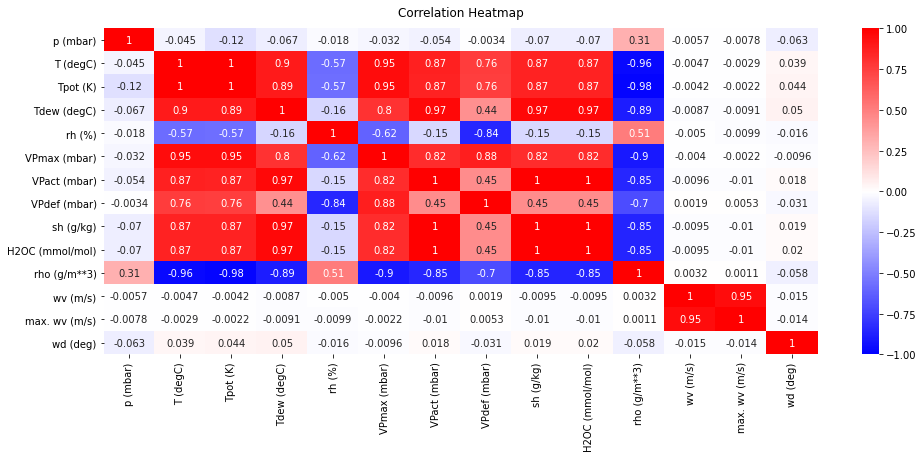

In [13]:
def plot_corr(df, columns=None):
    """plot the column-wise correlation of df using seaborn
    Args:
        df: dataframe
        columns: a list of column names
    
    """
    if columns:
        df1 = df[columns].copy()
    else:
        df1 = df.copy()
    import seaborn as sns
    # Increase the size of the heatmap.
    plt.figure(figsize=(16, 6))
    # Store heatmap object in a variable to easily access it when you want to include more features (such as title).
    # Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
    # cmap: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    heatmap = sns.heatmap(df1.corr(), vmin=-1, vmax=1, annot=True, cmap='bwr')
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
    
plot_corr(df)

You can observe that `Tpot (K)`, `Tdew (degC)`, `VPmax(mbar)`, `Vpact(mbar)`, `VPdef (mbar)`, `sh(g/kg)` and `H2OC` are highly positively correlated to the target `T (degC)`. Likewise, `rho` is highly negatively correlated to the target. 

In the features that are positively correlated, you can see that `VPmax (mbar)` is highly correlated to some features like `Vpact (mbar)`, `Tdew (degC)` and `Tpot (K)`. Hence, for the sake of this exercise you can drop these features and retain `VPmax (mbar)`. This step will be done in the Transform module.

#### Distribution of Wind Data

The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. However, angles in this current format do not make good model inputs. 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. This will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector. Observe how sine and cosine are used to generate wind vector features (`Wx` and `Wy`) in the Transform module below.

#### Date Time Feature

Similarly, the `Date Time` column is very useful but not in the current string format. First, you need to convert it to to seconds. Being weather data, it has clear daily and yearly periodicity, and you need to take that into account.

A simple approach to convert it to a usable signal is to again use sine and cosine to convert the time to clear "Time of day" (`Day sin`, `Day cos`) and "Time of year" (`Year sin`, `Year cos`) signals. 

### Transform Module

With the three points above considered, you can now build the transform module.

In [20]:
# Set the constants module filename
_weather_constants_module_file = 'weather_constants.py'

In [21]:
%%writefile {_weather_constants_module_file}

# Selected numeric features to transform
SELECTED_NUMERIC_FEATURES = ['T (degC)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)','rho (g/m**3)']

# Utility function for renaming the feature
def transformed_name(key):
    return key + '_xf'

Writing weather_constants.py


In [22]:
# Set the transform module filename
_weather_transform_module_file = 'weather_transform.py'

In [23]:
%%writefile {_weather_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

import weather_constants
import tensorflow_addons as tfa

import math as m

# Features to filter out
FEATURES_TO_REMOVE = ["Tpot (K)", "Tdew (degC)","VPact (mbar)" , "H2OC (mmol/mol)", "max. wv (m/s)"]

# Unpack the contents of the constants module
_SELECTED_NUMERIC_FEATURE_KEYS = weather_constants.SELECTED_NUMERIC_FEATURES
_transformed_name = weather_constants.transformed_name

# Define the transformations
def preprocessing_fn(inputs):
    """Preprocess input columns into transformed columns."""

    outputs = inputs.copy()

    # Filter redundant features
    for key in FEATURES_TO_REMOVE:
        del outputs[key]

    # Convert degrees to radians
    pi = tf.constant(m.pi)
    wd_rad = inputs['wd (deg)'] * pi / 180.0

    # Calculate the wind x and y components.
    outputs['Wx'] = inputs['wv (m/s)'] * tf.math.cos(wd_rad)
    outputs['Wy'] = inputs['wv (m/s)'] * tf.math.sin(wd_rad)

    # Delete `wv (m/s)` after getting the wind vector
    del outputs['wv (m/s)']

    # Get day and year in seconds
    day = tf.cast(24*60*60, tf.float32)
    year = tf.cast((365.2425)*day, tf.float32)

    # Convert `Date Time` column into timestamps in seconds (using tfa helper function)
    timestamp_s = tfa.text.parse_time(outputs['Date Time'], time_format='%d.%m.%Y %H:%M:%S', output_unit='SECOND')
    timestamp_s = tf.cast(timestamp_s, tf.float32)
    
    # Convert timestamps into periodic signals
    outputs['Day sin'] = tf.math.sin(timestamp_s * (2 * pi / day))
    outputs['Day cos'] = tf.math.cos(timestamp_s * (2 * pi / day))
    outputs['Year sin'] = tf.math.sin(timestamp_s * (2 * pi / year))
    outputs['Year cos'] = tf.math.cos(timestamp_s * (2 * pi / year))

    # Delete unneeded columns
    del outputs['Date Time']
    del outputs['wd (deg)']

    # Final feature list
    FINAL_FEATURE_LIST =  ["p (mbar)",
    "T (degC)",
    "rh (%)", 
    "VPmax (mbar)", 
    "VPdef (mbar)", 
    "sh (g/kg)",
    "rho (g/m**3)",
    "Wx",
    "Wy",
    "Day sin",
    'Day cos',
    'Year sin',
    'Year cos'
    ]

    # Scale selected numeric features
    for key in _SELECTED_NUMERIC_FEATURE_KEYS:
        outputs[key] = tft.scale_to_0_1(outputs[key])

    return outputs

Writing weather_transform.py


Run the `Transform` component below to perform the transformations.

In [24]:
# Ignore TF warning messages
tf.get_logger().setLevel('ERROR')

# Instantiate the Transform component
transform = Transform(
    examples=example_gen.outputs['examples'], # splited-formated df
    schema=schema_gen.outputs['schema'], # schema
    module_file=os.path.abspath(_weather_transform_module_file)) #the transform fnt

# Run the component
context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 10
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 9
        type_id: 13
        uri: "./pipeline/Transform/transform_graph/10"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 13
        name: "TransformGraph"
        )]
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 10
        type_id: 5
        uri: "./pipeline/Transform/transformed_examples/10"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 11
        type_id: 14
        uri: "./pipeline/Transform/updated_analyzer_cache/10"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        , artifact_type: id: 14
        name: "TransformCache"
        )]
        ))

As a sanity check, let's preview the results in the following cells.

In [25]:
# Get the URI of the output artifact representing the transformed examples
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
transformed_dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [26]:
# Define a helper function to get individual examples
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''
    
    # initialize an empty list
    records = []
    
    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):
        
        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()
        
        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()
        
        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)
        
        # convert the protocol bufffer message to a Python dictionary
        example_dict = (MessageToDict(example))
        
        # append to the records list
        records.append(example_dict)
        
    return records

In [27]:
# Get 3 records from the dataset
sample_records_xf = get_records(transformed_dataset, 3)

# Print the output
pp.pprint(sample_records_xf)

[{'features': {'feature': {'Day cos': {'floatList': {'value': [0.9988126]}},
                           'Day sin': {'floatList': {'value': [0.048717435]}},
                           'T (degC)': {'floatList': {'value': [0.2486316]}},
                           'VPdef (mbar)': {'floatList': {'value': [0.0047815694]}},
                           'VPmax (mbar)': {'floatList': {'value': [0.03788602]}},
                           'Wx': {'floatList': {'value': [-0.9119556]}},
                           'Wy': {'floatList': {'value': [0.47878695]}},
                           'Year cos': {'floatList': {'value': [0.9999552]}},
                           'Year sin': {'floatList': {'value': [0.009468557]}},
                           'p (mbar)': {'floatList': {'value': [996.52]}},
                           'rh (%)': {'floatList': {'value': [93.3]}},
                           'rho (g/m**3)': {'floatList': {'value': [0.7432129]}},
                           'sh (g/kg)': {'floatList': {'value': [0

## Prepare Training Datasets from TFTransformOutput ¶


Now that you have the transformed dataset, you can process this further depending on the model you will be training. For time series data, it makes sense to group a fixed-length series of measurements and map that to the label found in a future time step. For example, 3 days of data can be used the predict the next day's humidity. You can use the [tf.data.Dataset.window()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) method to implement these groupings.

In this exercise, you will use data from the last 5 days to predict the temperature 12 hours into the future. 

* You already know that data is taken every 10 minutes so there will be 720 data points for 5 days. 
* You will also assume that drastic change is not expected within an hour so you will **downsample** the 720 data points to 120 by just getting the data every hour. Thus, you will use a *stride* (or step size) of 6 when getting the data points. This makes the `HISTORY_SIZE` for the feature window equal to 120. 
* For this single step prediction model (forecasting), the label for a dataset window will be the temperature 12 hours into the future.
* By default, the `window()` method moves `size` (i.e. window size) steps at a time. For example, if you have a dataset with elements `[1, 2, 3, 4]` and you have `size=2`, then your results will look like: `[1, 2], [3, 4]`. You can reconfigure this behavior and move at smaller or larger steps with the `shift` parameter. For the same sample dataset with window `size=2` but with `shift=1`, the results will look like `[1, 2], [2,3], [3,4]` because the window is moving `1` element at a time.

In [28]:
# Constants to prepare the transformed data for modeling

WORKING_DIR = transform.outputs['transform_graph'].get()[0].uri
LABEL_KEY = 'T (degC)'
OBSERVATIONS_PER_HOUR = 6
HISTORY_SIZE = 120
FUTURE_TARGET = 12
BATCH_SIZE = 72
SHIFT = 1

You first need to get a wrapper to the transform graph so you can get information from it. That is done with the `tft.TFTransformOutput()` method and we can use it to extract the index of our label.

In [29]:
import tensorflow_transform as tft

# Get the output of the Transform component
tf_transform_output = tft.TFTransformOutput(os.path.join(WORKING_DIR))

# Get the index of the label key
index_of_label = list(tf_transform_output.transformed_feature_spec().keys()).index(LABEL_KEY)
print(index_of_label)

2


Next, you will define several helper functions to extract the data from your transformed dataset and group it into windows. First, this `parse_function()` will help in getting the transformed features and rearranging them so that the label values (i.e. `T (degC)`) is at the end of the tensor.

In [30]:
def parse_function(example_proto):
    """getting the transformed features and rearranging them so that the label values (i.e. T (degC)) is at the end of the tensor"""
    feature_spec = tf_transform_output.transformed_feature_spec()
    
    # Define features with the example_proto (transformed data) and the feature_spec using tf.io.parse_single_example 
    features = tf.io.parse_single_example(example_proto, feature_spec)
    values = list(features.values())
    values[index_of_label], values[len(features) - 1] = values[len(features) - 1], values[index_of_label]
    
    # Stack the values along the first axis
    stacked_features = tf.stack(values, axis=0)

    return stacked_features

Next, this function will separate the features and target values into a tuple.

In [31]:
def map_features_target(elements):
    """separate the features and target values into a tuple"""
    features = elements[:HISTORY_SIZE]
    target = elements[-1:,-1]
    return (features, target)

In [35]:
path_to_train_tfrecord_files

'./pipeline/Transform/transformed_examples/10/train/transformed_examples-00000-of-00001.gz'

Finally, you can define the dataset window with the function below. It uses the parameters defined above and also the helper functions to produce the batched feature-target mappings.

In [32]:
def get_dataset(path):
    """define the dataset window and produce the batched feature-target mappings.
    Args:
        path(string): the path to the transformed examples i.e. './pipeline/Transform/transformed_examples/10/train/transformed_examples-00000-of-00001.gz'
        
    Returns:
        dataset: 
    """
    # Instantiate a tf.data.TFRecordDataset passing in the appropiate path
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP')
    
    # Use the dataset's map method to map the parse_function
    dataset = dataset.map(parse_function)
    
    # Use the window method with expected total size. Define stride and set drop_remainder to True
    dataset = dataset.window(HISTORY_SIZE + FUTURE_TARGET, shift=SHIFT, stride=OBSERVATIONS_PER_HOUR, drop_remainder=True)
    
    # Use the flat_map method passing in an anonymous function that given a window returns window.batch(HISTORY_SIZE + FUTURE_TARGET)
    dataset = dataset.flat_map(lambda window: window.batch(HISTORY_SIZE + FUTURE_TARGET))
    
    # Use the map method passing in the previously defined map_features_target function
    dataset = dataset.map(map_features_target) 
    
    # Use the batch method and pass in the appropiate batch size
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

You can now use the `get_dataset()` function on your transformed examples to produce the dataset windows.

In [33]:
# Get the URI of the transformed examples
working_dir = transform.outputs['transformed_examples'].get()[0].uri

# Get the filename of the compressed examples
train_tfrecord_files = os.listdir(working_dir + '/train')[0]

# Full path string to the training tfrecord files
path_to_train_tfrecord_files = os.path.join(working_dir, 'train', train_tfrecord_files)

# Get the window datasets by passing the full path to the get_dataset function
train_dataset = get_dataset(path_to_train_tfrecord_files)

Let's preview the resulting shapes of the data windows. If we print out the shapes of the tensors in a single batch, you'll notice that it indeed produced the required dimensions. It has 72 examples per batch where each contain 120 measurements for each of the 13 features in the transformed dataset. The target tensor shape only has one feature per example in the batch as expected (i.e. only `T (degC)`).

In [34]:
for features, target in train_dataset.take(1):
    print(f'Shape of input features for a batch: {features.shape}')
    print(f'Shape of targets for a batch: {target.shape}')

Shape of input features for a batch: (72, 120, 13, 1)
Shape of targets for a batch: (72, 1, 1)


## Wrap Up

In this notebook, you got to see how you may want to prepare seasonal data. It shows how you can handle periodicity and produce batches of dataset windows. You will be doing something similar in the next lab with sensor data. This time though, the measurements are taken at a much higher rate (20 Hz). The labels are also categorical so you will be handling that differently.

On to the next!